In [3]:
!pip install tiktoken==0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.0 MB/s eta 0:00:00


In [5]:
os.chdir("/content/drive/MyDrive/Build-LLM-From-Scratch")

In [6]:
import tiktoken
import pandas as pd
import torch
import os
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from model import GPTModel
from utilities import generate, text_to_ids, ids_to_text
from load_gpt2_small_weights import download_and_save, get_new_config, load_weights_into_gpt

In [9]:
data_file_path = "sms_spam_collection/SMSSpamCollection.tsv"
df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [11]:
def create_balanced_dataset(df):
    spam_subset = df[df["Label"] == "spam"]
    num_spam = spam_subset.shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state = 123)
    balanced_df = pd.concat([ham_subset, spam_subset])
    return balanced_df

In [12]:
balanced_df = create_balanced_dataset(df)

In [13]:
balanced_df.shape

(1494, 2)

In [14]:
balanced_df.head()

,Label,Text
4307,ham,Awww dat is sweet! We can think of something t...
4138,ham,Just got to &lt;#&gt;
4831,ham,"The word ""Checkmate"" in chess comes from the P..."
4461,ham,This is wishing you a great day. Moji told me ...
5440,ham,Thank you. do you generally date the brothas?


In [15]:
balanced_df["Label"].value_counts()

,count
Label,
ham,747
spam,747


In [16]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})

In [17]:
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [18]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

In [19]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [20]:
train_df = pd.read_csv("train.csv")
validation_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

In [21]:
print(train_df.shape, validation_df.shape, test_df.shape)

(1045, 2) (149, 2) (300, 2)


In [22]:
tokenizer = tiktoken.get_encoding("gpt2")
pad_token_id = tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"})
print(pad_token_id)

[50256]


In [23]:
class SpamDataset(Dataset):
    def __init__(self, df_path, tokenizer, max_len=None, pad_token_id = pad_token_id):
        super().__init__()
        self.data = pd.read_csv(df_path)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_len is None:
            self.max_len = self._longest_encoded_length()
        else:
            self.max_len = max_len
            self.encoded_texts = [encoded_text[:self.max_len] for encoded_text in self.encoded_texts]

        self.encoded_texts = [encoded_text + pad_token_id * (self.max_len - len(encoded_text)) for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_len = 0
        for encoded_text in self.encoded_texts:
            if len(encoded_text) > max_len:
                max_len = len(encoded_text)
        return max_len

In [24]:
train_dataset = SpamDataset(
    df_path="train.csv",
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    df_path="validation.csv",
    max_len= train_dataset.max_len,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    df_path="test.csv",
    max_len= train_dataset.max_len,
    tokenizer=tokenizer
)

In [25]:
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(train_dataset.max_len)
print(train_dataset[0])

1045 149 300
120
(tensor([   35,  2507,   703,   466,   345,   588,   262,  6940,  2344,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]), tensor(0))


In [26]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    train_dataset,
    batch_size= batch_size,
    shuffle= True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size= batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size= batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [27]:
print("Training Instances : ", len(train_dataset))
print("Validation Instances : ", len(val_dataset))
print("Test Instances : ", len(test_dataset))
print("Training Batches : ", len(train_loader))
print("Validation Batches : ", len(val_loader))
print("Test Batches : ", len(test_loader))

Training Instances :  1045
Validation Instances :  149
Test Instances :  300
Training Batches :  130
Validation Batches :  19
Test Batches :  38


In [28]:
for input_batch, target_batch in train_loader:
    print("Input shape : ", input_batch.shape)
    print("Target shape : ", target_batch.shape)

Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape :  torch.Size([8])
Input shape :  torch.Size([8, 120])
Target shape

In [29]:
settings, params = download_and_save()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NEW_CONFIG = get_new_config()
gpt = GPTModel(NEW_CONFIG)
load_weights_into_gpt(gpt, params)
gpt.to(device)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_f

In [32]:
torch.manual_seed(123)
gpt.to('cpu')
text_1 = "Every effort moves you"
token_ids = generate(
    model=gpt,
    idx=text_to_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=NEW_CONFIG["context_length"]
)
print(ids_to_text(token_ids, tokenizer))


Every effort moves you can't make.


The only way to make a good game


In [33]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate(
    model=gpt,
    idx=text_to_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=NEW_CONFIG["context_length"]
)
print(ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': Answer with 'yes'


In [34]:
print(gpt)

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_f

In [35]:
for param in gpt.parameters():
    param.requires_grad = False

In [36]:
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(
    in_features= NEW_CONFIG["emb_dim"],
    out_features= num_classes
)

In [49]:
print(device)
gpt.to(device)

cuda


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_f

In [37]:
print(gpt)

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_f

In [38]:
for param in gpt.blocks[-1].parameters():
    param.requires_grad = True
for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [39]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)
with torch.no_grad():
    outputs = gpt(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)
print("Last output token:", outputs[:, -1, :])

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-3.3748,  0.7024],
         [-4.2846,  7.3137],
         [-2.7769,  6.4165],
         [-3.8983,  4.7593]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[-3.8983,  4.7593]])


In [40]:
probs = torch.softmax(outputs[:, -1, :], dim= -1)
print(probs)
label = torch.argmax(probs)
print(label)

tensor([[1.7378e-04, 9.9983e-01]])
tensor(1)


In [41]:
def calc_batch_loss(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [42]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_batch_loss(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [43]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [44]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_preds, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0] # or input_batch.shape[0]
            correct_preds += ((predicted_labels == target_batch).sum().item())
        else:
            break

    return correct_preds / num_examples

In [45]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    example_seen, global_step = 0, -1
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_batch_loss(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            example_seen += input_batch.size(0)
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, "
                        f"Val loss {val_loss:.3f}")

        train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_acc*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_acc*100:.2f}%")
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs, example_seen

In [50]:
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.01 )
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, example_seen = train_classifier_simple(
    model=gpt,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

Ep 1 (Step 000000): Train loss 2.158, Val loss 2.397
Ep 1 (Step 000050): Train loss 0.856, Val loss 0.880
Ep 1 (Step 000100): Train loss 0.611, Val loss 0.722


 20%|██        | 1/5 [00:11<00:47, 12.00s/it]

Training accuracy: 90.00% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.613, Val loss 0.618
Ep 2 (Step 000200): Train loss 0.698, Val loss 0.648
Ep 2 (Step 000250): Train loss 0.535, Val loss 0.622


 40%|████      | 2/5 [00:23<00:34, 11.58s/it]

Training accuracy: 57.50% | Validation accuracy: 57.50%
Ep 3 (Step 000300): Train loss 0.440, Val loss 0.535
Ep 3 (Step 000350): Train loss 0.431, Val loss 0.467


 60%|██████    | 3/5 [00:34<00:22, 11.24s/it]

Training accuracy: 72.50% | Validation accuracy: 65.00%
Ep 4 (Step 000400): Train loss 0.285, Val loss 0.539
Ep 4 (Step 000450): Train loss 0.466, Val loss 0.415
Ep 4 (Step 000500): Train loss 0.421, Val loss 0.477


 80%|████████  | 4/5 [00:45<00:11, 11.34s/it]

Training accuracy: 85.00% | Validation accuracy: 80.00%
Ep 5 (Step 000550): Train loss 0.368, Val loss 0.376
Ep 5 (Step 000600): Train loss 0.401, Val loss 0.400


100%|██████████| 5/5 [00:56<00:00, 11.33s/it]

Training accuracy: 85.00% | Validation accuracy: 80.00%


In [52]:
import matplotlib.pyplot as plt
def plot_values(
    epochs_seen, examples_seen, train_values, val_values,
    label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
    epochs_seen, val_values, linestyle="-.",
    label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

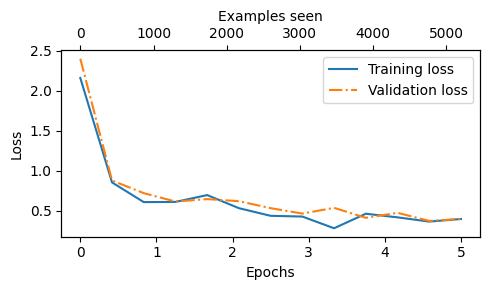

In [53]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

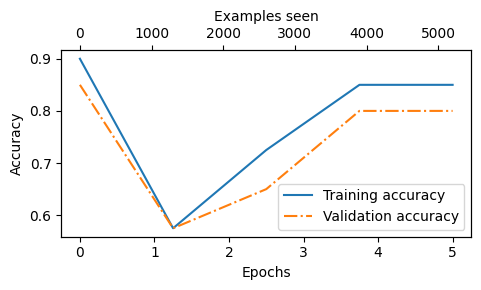

In [78]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_accs))
plot_values(
 epochs_tensor, examples_seen_tensor, train_accs, val_accs,
 label="accuracy"
)

In [56]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 81.63%
Validation accuracy: 79.87%
Test accuracy: 83.33%


In [72]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id = pad_token_id):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.position_embedding.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += pad_token_id * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "ham"

In [73]:
text_1 = (
 "You are a winner you have been specially"
 " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
 text_1, gpt, tokenizer, device, max_length=train_dataset.max_len
))

spam


In [75]:
text_2 = (
 "Hey, just wanted to check if we're still on"
 " for dinner tonight? Let me know!"
)
print(classify_review(
 text_2, gpt, tokenizer, device, max_length=train_dataset.max_len
))

ham


In [81]:
torch.save(gpt.state_dict(), "review_classifier.pth")

In [83]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
gpt.load_state_dict(model_state_dict)

<ipython-input-83-4f23e543c44b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth", map_location=device)


<All keys matched successfully>